In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/SW엔지니어

/content/drive/MyDrive/Colab Notebooks/SW엔지니어


#### RNN 활용하기 : 네이버 영화 리뷰 데이터 감성분석


word 단위로 학습하기
- 데이터 로딩
- 결측치 제거
- 문제, 답 분리

In [ ]:
# 데이터 로딩
import pandas as pd
train_df = pd.read_csv('./data/ratings_train.txt', delimiter ='\t')
test_df = pd.read_csv('./data/ratings_test.txt', delimiter ='\t')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171075 entries, 0 to 171074
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        171075 non-null  object 
 1   document  171069 non-null  object 
 2   label     171074 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
# 결측치 제거
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171068 entries, 0 to 171074
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        171068 non-null  object 
 1   document  171068 non-null  object 
 2   label     171068 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.2+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49997 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49997 non-null  int64 
 1   document  49997 non-null  object
 2   label     49997 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


#### 학습을 위한 추가 전처리
- 특수문자 제거
- 불용어 제거
- 형태소 분리 (어간 추출 + 정규화)
- 인코딩 (라벨인코딩 방식 활용) + 길이(순환 횟수) 맞추기

In [51]:
import re

In [ ]:
# 특수문자 제거를 위한 정규표현식 패턴 설정
pattern = re.compile(r'[^a-zA-Z0-9가-힇\s\.\?\!]')
# ^a-zA-Z0-9가-힇\s\.\?\! : ^모든. a-Z 알파뱃(대,소문자). 가-힇 한글. \s 공백 문자(스페이스, 탭, 줄바꿈 등. \.\?\! 자주쓰는 특수문자)

In [ ]:
example_review = "오늘 영화 Review 평점은 10점 만점에 9.7!! 너무 재밌습니다 😎😂👍 #꿀잼영화 #감동"

In [ ]:
# re.sub : (정규 표현식, 문자열, 바꿀 대상 문자열) > 문자열 치환 함수
re.sub(pattern, "", example_review)

'오늘 영화 Review 평점은 10점 만점에 9.7!! 너무 재밌습니다  꿀잼영화 감동'

In [ ]:
!pip -q install konlpy kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 28.7 MB/s eta 0:00:00


In [52]:
from kiwipiepy.utils import Stopwords
# 불용어 : 자주 등장하지만 분석에 큰 의미가 없는 단어들

ModuleNotFoundError: No module named 'kiwipiepy'

In [ ]:
stopwords = Stopwords()

In [ ]:
# 불용어 사전 확인
print(stopwords.stopwords)

{('성', 'XSN'), ('와', 'JKB'), ('는', 'JX'), ('며', 'EC'), ('을', 'JKO'), ('도', 'JX'), ('ᆯ', 'ETM'), ('과', 'JKB'), ('말', 'NNG'), ('으로', 'JKB'), ('나', 'NP'), ('한', 'MM'), ('ᆫ다', 'EF'), ('ᆫ', 'ETM'), ('그', 'NP'), ('은', 'JX'), ('있', 'VX'), ('사람', 'NNG'), ('겠', 'EP'), ('이', 'JKC'), ('것', 'NNB'), ('이', 'JKS'), ('때문', 'NNB'), ('있', 'VV'), ('그', 'MM'), ('되', 'XSV'), ('때', 'NNG'), ('없', 'VA'), ('화', 'XSN'), ('이', 'NP'), ('하', 'XSV'), ('어', 'EC'), ('면', 'EC'), ('어서', 'EC'), ('던', 'ETM'), ('다', 'EF'), ('같', 'VA'), ('ᆫ', 'JX'), ('다는', 'ETM'), ('보', 'VV'), ('명', 'NNB'), ('지', 'VX'), ('되', 'VV'), ('가', 'JKS'), ('하', 'VX'), ('위하', 'VV'), ('받', 'VV'), ('일', 'NNB'), ('지', 'EC'), ('월', 'NNB'), ('하', 'VV'), ('어', 'EF'), ('아니', 'VCN'), ('와', 'JC'), ('수', 'NNB'), ('의', 'JKG'), ('지역', 'NNG'), ('따르', 'VV'), ('고', 'JKQ'), ('부터', 'JX'), ('과', 'JC'), ('년', 'NNB'), ('하', 'XSA'), ('통하', 'VV'), ('만', 'JX'), ('에서', 'JKB'), ('이', 'MM'), ('까지', 'JX'), ('지만', 'EC'), ('등', 'NNB'), ('제', 'XPN'), ('이', 'VCP'), ('더', 'MAG'), 

In [ ]:
stopwords_list = [word for word, tag in stopwords.stopwords]

# stopwords_list = []
# for word, tag in stopwords.stopwords:
#  stopwords_list.append(word)

In [ ]:
print(stopwords_list)

['성', '와', '는', '며', '을', '도', 'ᆯ', '과', '말', '으로', '나', '한', 'ᆫ다', 'ᆫ', '그', '은', '있', '사람', '겠', '이', '것', '이', '때문', '있', '그', '되', '때', '없', '화', '이', '하', '어', '면', '어서', '던', '다', '같', 'ᆫ', '다는', '보', '명', '지', '되', '가', '하', '위하', '받', '일', '지', '월', '하', '어', '아니', '와', '수', '의', '지역', '따르', '고', '부터', '과', '년', '하', '통하', '만', '에서', '이', '까지', '지만', '등', '제', '이', '더', '를', '주', '다고', '들', '적', '일', '에', '중', '라는', '대하', '고', '우리', '는', '게', '않', '기', '었', '다', '면서', '원', '로', '라', '을', '만', '어야', '에게', '은']


In [53]:
from konlpy.tag import Okt

ModuleNotFoundError: No module named 'konlpy'

In [ ]:
okt = Okt()

In [ ]:
# 품사 태깅(pos tagging) 예시
temp = okt.pos(
    '예시 문장 : 점심식사 맛있게 하셨습니까?',
    stem = True,    # 어간 추출 (먹었다, 먹었음, 먹었어요 - > '먹다')
    norm = True     # 정규화 (입력 문장을 표준화 된 형태소로 변환하거나 비표준표현 삭제)
)
temp

[('예시', 'Noun'),
 ('문장', 'Noun'),
 (':', 'Punctuation'),
 ('점심식사', 'Noun'),
 ('맛있다', 'Adjective'),
 ('하다', 'Verb'),
 ('?', 'Punctuation')]

In [ ]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [ ]:
# 전처리 함수 정의
def preprocess_text(text):
  # 1. 특수문자 제거, 소문자 변환, 양끝 공백 제거
  text = re.sub(pattern,"",text).lower().strip()

  # 2. 형태소 분석 (어간 추출+정규화)
  pos_tags = okt.pos(text, stem=True, norm=True)

  # 3. 명사, 형용사, 동사만 남기고 kiwi Stopwords에 있는 불용어는 필터링
  tokens = [
      word for word, tag in pos_tags
      if tag in ['Noun', 'Verb', 'Adjective'] and word not in stopwords_list
  ]
  return " ".join(tokens) # 공백으로 이어서 문자열로 반환

In [ ]:
from tqdm.auto import tqdm

In [ ]:
tqdm.pandas()

In [ ]:
X_train_clean = train_df['document'].progress_apply(preprocess_text)
X_test_clean = test_df['document'].progress_apply(preprocess_text)

  0%|          | 0/171068 [00:00<?, ?it/s]

  0%|          | 0/49997 [00:00<?, ?it/s]

In [ ]:
X_train_clean.shape, X_test_clean.shape

((171068,), (49997,))

In [ ]:
X_train_clean.head()

,document
0,더빙 진짜 짜증나다 목소리
1,흠 포스터 보고 초딩 영화 줄 오버 연기 가볍다 않다
2,무재 밓었 다그 래서 보다 추천
3,교도소 이야기 구먼 솔직 재미 없다 평점 조정
4,몬페 익살스럽다 연기 돋보이다 영화 스파이더맨 늙다 보이다 하다 커스틴 던스트 이쁘...


In [ ]:
# label 분리
y_train = train_df['label']
y_test = test_df['label']

### 전처리 완료된 데이터 저장

In [3]:
import pickle

In [ ]:
# 저장
with open('./data/X_train_morphs.pkl', 'wb') as f:
  pickle.dump(X_train_clean, f)
with open('./data/X_test_morphs.pkl', 'wb') as f:
  pickle.dump(X_test_clean, f)

with open('./data/y_train.pkl', 'wb') as f:
  pickle.dump(y_train, f)
with open('./data/y_test.pkl', 'wb') as f:
  pickle.dump(y_test, f)

#### 데이터 불러오기

In [4]:
# 로딩
with open('./data/X_train_morphs.pkl', 'rb') as f:
  X_train_clean = pickle.load(f)
with open('./data/X_test_morphs.pkl', 'rb') as f:
  X_test_clean = pickle.load(f)

with open('./data/y_train.pkl', 'rb') as f:
  y_train = pickle.load(f)
with open('./data/y_test.pkl', 'rb') as f:
  y_test = pickle.load(f)

#### 시퀀스 변환 준비
- 토큰화 : 문장을 특정 기준에 맞춰 쪼개는 것
  - 글자단위, 단어단위(띄어쓰기), 형태소단위(명사,형용사,동사 등)
- 수치화 : 잘라진 토큰을 일정 기준(알고리즘)에 맞춰 숫자로 변경하는 것
- 빈도인코딩, 원핫인코딩, 라벨인코딩, BOW, Tf-idf 등

In [5]:
from tensorflow.keras.layers import TextVectorization
# 텍스트 데이터를 토큰화, 수치화로 모델학습용 데이터로 변경하는 클래스

In [6]:
tv = TextVectorization(
    # 사전에서 사용할 최대 단어 수 설정
    max_tokens = 5000,

    # 텍스트를 어떻게 변환할지 지정하는 옵션
    output_mode='int', # 텍스트를 정수 인덱스로 변환하여 각 단어에 해당하는 정수 출력

    # 텍스트 데이터를 표준화하는 방식 지정 (텍스트가 일관된 형식으로 정리됨)
    standardize ='lower_and_strip_punctuation', # 소문자 변환, 구두점 제거 default 값

    # 출력되는 정수 시퀀스 최대 길이 고정. (짧으면 패딩(0)으로 채움, 길면 자름)
    output_sequence_length=10
)

In [7]:
# 훈련데이터 기반으로 전처리, 토큰화, 단어사전 구축
tv.adapt(X_train_clean)

In [30]:
# 단어사전의 수 확인 max_tokens = 5000
tv.vocabulary_size()

5000

In [31]:
# 단어 토큰 확인
print(tv.get_vocabulary())
# UNK : unknown 토큰. 단어사전에 등록되지 않은 단어를 표현하는 토큰

['', '[UNK]', '영화', '하다', '보다', '없다', '있다', '좋다', '재밌다', '정말', '되다', '같다', '진짜', '이다', '점', '아니다', '않다', '만들다', '나오다', '연기', '평점', '최고', '왜', '스토리', '생각', '드라마', '감동', '보고', '아깝다', '이렇다', '내', '배우', '재미있다', '거', '감독', '들다', '뭐', '내용', '재미', '그냥', '주다', '좀', '재미없다', '자다', '지루하다', '쓰레기', '시간', '가다', '모르다', '그렇다', '싶다', '작품', '사랑', '알다', '다시', '하나', '오다', '볼', '마지막', '완전', '처음', '정도', '많다', '장면', '주인공', '액션', '차다', '안되다', '최악', '나다', '지금', '별로', '돈', '이야기', '걸', '임', '연출', '넘다', '느낌', '개', '끝', '듯', '좋아하다', '명작', '역시', '받다', '남다', '이해', '괜찮다', '안', '이영화', '버리다', '느끼다', '또', '여자', '먹다', '아름답다', '편', '난', '해주다', '꼭', '기억', '보기', '결말', '마음', '어떻다', '인생', '아쉽다', '소재', '뻔하다', '애', '끄다', '못', '보여주다', '어리다', '수준', '무섭다', '재다', '맞다', '한번', '반전', '현실', '가장', '매력', '웃기다', '전개', '되어다', '한국', '가슴', '남자', '끝나다', '말다', '낮다', '알', '높다', '슬프다', '죽다', '유치하다', '음악', '멋지다', '아이', '원작', '저', '줄', '늘다', '눈물', '크다', '쓰다', '무슨', '추천', '인간', '함', '내다', '살다', '야하다', '속', '눈', '자체', '번', '찍다', '허다', '솔직', '짜증나다', 

In [8]:
# 학습 데이터를 벡터화하여 정수 시퀀스로 변환
X_train_vec = tv(X_train_clean)

In [17]:
X_train_vec.shape

# 전체 데이터 개수, 시퀀스 길이.순환 횟수(time step)

TensorShape([171068, 10])

In [18]:
X_train_clean[0]
# 더빙, 진짜, 짜증나다, 목소리 4개의 토큰

'더빙 진짜 짜증나다 목소리'

In [19]:
X_train_vec[0]
# 토큰마다의 시퀀스 번호. 더빙 : 348, 진짜 : 12, 짜증나다 : 162, 목소리 : 496, 나머지 시퀀스 : 0 으로 지정.

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([348,  12, 162, 496,   0,   0,   0,   0,   0,   0])>

In [9]:
# test 데이터 변경
X_test_vec = tv(X_test_clean)
X_test_vec.shape

TensorShape([49997, 10])

In [10]:
import numpy as np

In [11]:
# 입력 데이터의 shape를 3차원으로 만들어주기. (171068, 10, 1)로 변환 후 학습 필요
X_train_vec = np.expand_dims(X_train_vec, axis=-1) # -1 : 마지막 축(axis)에 새로운 차원 추가
X_test_vec = np.expand_dims(X_test_vec, axis=-1)

In [ ]:
# 최종 모양 확인
X_train_vec.shape,X_test_vec.shape
# 약 17만개의 리뷰 데이터, 10개의 시퀀스 길이(순환 횟수), 벡터는 1개의 특성(정수 인덱스)

((171068, 10, 1), (49997, 10, 1))

### 학습
1. 모델 구조 정의
2. 학습방법 설정
3. 학습
4. 예측

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, InputLayer

In [ ]:
# 1. 모델 구조 정의
model = Sequential()

model.add(InputLayer(shape=(10,1))) # 입력층
model.add(SimpleRNN(units=64)) # 중간층
model.add(Dense(units=1, activation='sigmoid')) # 출력층. 이진분류(긍/부정)

# 2. 학습 방법 설정
model.compile(loss='binary_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

# 3. 모델 학습
his = model.fit(X_train_vec, y_train,
                epochs = 40,
                batch_size = 128,
                validation_split = 0.2)

Epoch 1/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5229 - loss: 0.6936 - val_accuracy: 0.5279 - val_loss: 0.6869
Epoch 2/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5372 - loss: 0.6851 - val_accuracy: 0.5375 - val_loss: 0.6844
Epoch 3/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5359 - loss: 0.6825 - val_accuracy: 0.5379 - val_loss: 0.6838
Epoch 4/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5407 - loss: 0.6798 - val_accuracy: 0.5440 - val_loss: 0.6795
Epoch 5/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5410 - loss: 0.6772 - val_accuracy: 0.5408 - val_loss: 0.6754
Epoch 6/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5453 - loss: 0.6735 - val_accuracy: 0.5435 - val_loss: 0.6715
Epoch 7/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5436 - loss: 0.6724 - val_accuracy: 0.5479 - val_loss: 0.6720
Epoch 8/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5487 - loss: 0.671

In [64]:
# 학습 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(his.history['accuracy'], label='train_acc')
plt.plot(his.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

NameError: name 'his' is not defined

<Figure size 1200x400 with 0 Axes>

In [ ]:
pred = model.predict(X_test_vec)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
pred

array([[0.43445054],
       [0.4051934 ],
       [0.41858596],
       ...,
       [0.42880237],
       [0.5506896 ],
       [0.6759807 ]], dtype=float32)

In [ ]:
# 이진분류(sigmoid) -> 0.5를 기준으로 클래스 나누기
pred_cls = (pred > 0.5).astype('int')
pred_cls

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [ ]:
y_test_sample = y_test.copy() # y_test의 복사본을 변수 sample로 만듦

In [ ]:
y_test_sample = pd.DataFrame(y_test_sample) # 2차원 df로 만듦

In [ ]:
y_test_sample['rnn_pred_cls'] = pred_cls # 'rnn_pred_cls' 컬럼 추가

In [ ]:
y_test_sample # 실제답, rnn이 예측한 클래스 값 비교

,label,rnn_pred_cls
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
49995,1,0
49996,0,1
49997,0,0
49998,0,1


In [ ]:
# 모델 전체 평가. X_test, y_test 기준
model.evaluate(X_test_vec, y_test)
# 학습 데이터 정확도 66%, 테스트 데이터 정확도 55%

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5560 - loss: 0.6617


[0.6625497341156006, 0.5554733276367188]

### SimpleRNN(바닐라RNN)의 경우 긴 시퀀스를 가진 데이터를 효과적으로 학습하기 어려움
- 순환횟수(시퀀스)가 길어질수록, 초반에 입력된 단어의 기억데이터가 소실되는 기울기 소실 현상이 발생함.
- 문장 구성 시 초반 단어가 후반 예측에 영향을 주는 경우, 바닐라RNN이 학습하기 어려움

# 06-23

# LSTM (Long Short Term Memory)
- 장기기억과 단기기억을 관리하는 계산이 추가된 RNN 모델
- 기존 RNN 구조에서 메모리 셀(Cell)이라는 개념이 추가됨
- 가중치를 통해 중요한 기억은 오래, 그렇지 않으면 줄여서 관리
- Forget, Input, Output 게이트를 사용함

In [65]:
from tensorflow.keras.layers import LSTM

# LSTM 모델링

In [11]:
# 모델 설계
lstm_model = Sequential()
lstm_model.add(InputLayer(shape=(10,1)))
lstm_model.add(LSTM(units=64))
lstm_model.add(Dense(units=1, activation='sigmoid'))

# 모델 학습 및 평가방법 설정
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [21]:
# 모델 학습
lstm_his = lstm_model.fit(X_train_vec, y_train,
                          validation_split=0.2,
                          epochs=40, batch_size=128)

Epoch 1/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5460 - loss: 0.6847 - val_accuracy: 0.5597 - val_loss: 0.6776
Epoch 2/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.5664 - loss: 0.6760 - val_accuracy: 0.5741 - val_loss: 0.6709
Epoch 3/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.5754 - loss: 0.6709 - val_accuracy: 0.5775 - val_loss: 0.6657
Epoch 4/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.5786 - loss: 0.6662 - val_accuracy: 0.5760 - val_loss: 0.6641
Epoch 5/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.5766 - loss: 0.6650 - val_accuracy: 0.5813 - val_loss: 0.6634
Epoch 6/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5823 - loss: 0.6622 - val_accuracy: 0.5853 - val_loss: 0.6661
Epoch 7/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5837 - loss: 0.6611 - val_accuracy: 0.5815 - val_loss: 0.6613
Epoch 8/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5886 -

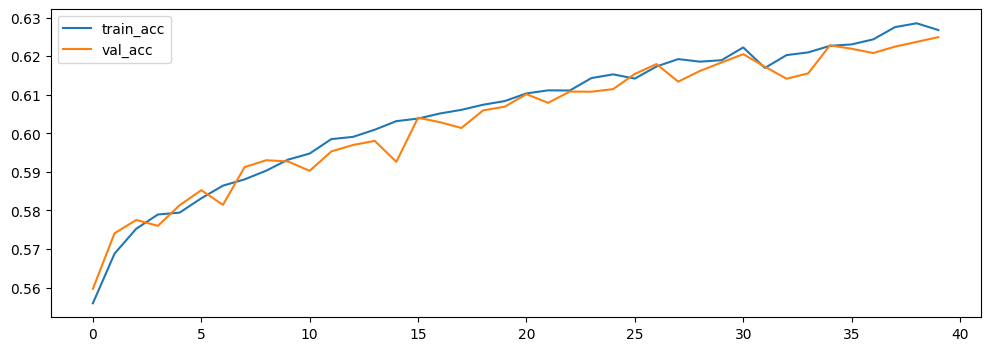

In [22]:
# 학습 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(lstm_his.history['accuracy'], label='train_acc')
plt.plot(lstm_his.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# GRU (Gated Recurrent Unit)
- LSTM의 복잡성을 줄인 순환 신경망(RNN)의 변형
- Reset Gate, Update Gate 두 가지만 사용
- 셀 상태(Cell state) 없이 은닉 상태(hidden state)하나만 관리

# GRU 모델링

In [66]:
from tensorflow.keras.layers import GRU

In [24]:
# 모델 설계
gru_model = Sequential()
gru_model.add(InputLayer(shape=(10,1)))
gru_model.add(GRU(units=64))
gru_model.add(Dense(units=1, activation='sigmoid'))

# 모델 학습 및 평가방법 설정
gru_model.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [25]:
# 모델 학습
gru_his = gru_model.fit(X_train_vec, y_train,
                          validation_split=0.2,
                          epochs=40, batch_size=128)

Epoch 1/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5437 - loss: 0.6856 - val_accuracy: 0.5592 - val_loss: 0.6773
Epoch 2/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.5624 - loss: 0.6769 - val_accuracy: 0.5686 - val_loss: 0.6723
Epoch 3/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5720 - loss: 0.6702 - val_accuracy: 0.5711 - val_loss: 0.6688
Epoch 4/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.5732 - loss: 0.6670 - val_accuracy: 0.5794 - val_loss: 0.6696
Epoch 5/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.5800 - loss: 0.6645 - val_accuracy: 0.5765 - val_loss: 0.6642
Epoch 6/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.5777 - loss: 0.6627 - val_accuracy: 0.5825 - val_loss: 0.6602
Epoch 7/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.5844 - loss: 0.6596 - val_accuracy: 0.5814 - val_loss: 0.6592
Epoch 8/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5908 -

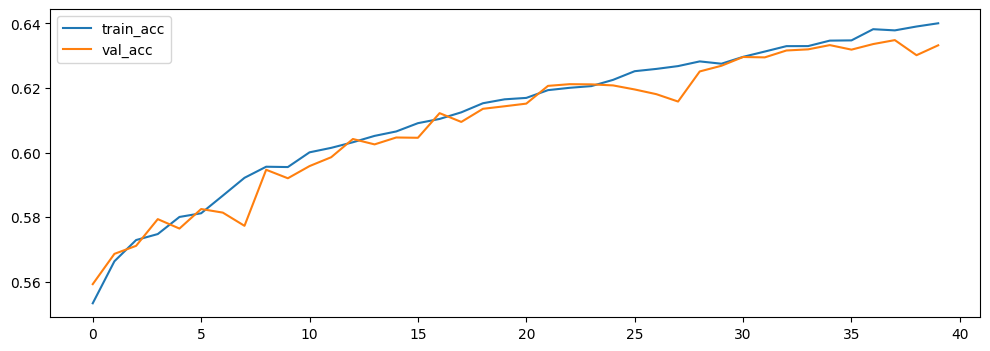

In [26]:
# 학습 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(gru_his.history['accuracy'], label='train_acc')
plt.plot(gru_his.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

### 워드 임베딩
- 인공지능 기반의 텍스트 마이닝, 자연어처리 모델링을 할 때 입력되는 데이터의 수치화가 필요
- 현재 라벨 인코딩 기반의 수치화는 모델이 단어의 빈도 패턴을 학습하는 것과 비슷
- 단어의 본질적인 의미를 파악할 수 있도록 수치화를 정교하게 해보자
- 워드 임베딩 : 단어 > 벡터. 표현 방법, 단어를 밀집 표현으로 변환

# word2vec 맛보기

In [3]:
!pip -q install -U gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# gensim : 텍스트마이닝, NLP 분야에 유용한 패키지

In [67]:
import gensim.downloader as api

In [3]:
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

In [4]:
# 사용 가능한 여러 모델 리스트 업
for model_name, model_data in sorted(api.info()['models'].items()):
  # num_records : 모델이 학습가능한 전체 단어 벡터 수
  num_records = model_data.get('num_records', -1)
  description = model_data['description'][:40] + '...'

  print( f'{model_name} ({num_records} records: {description})')

__testing_word2vec-matrix-synopsis (-1 records: [THIS IS ONLY FOR TESTING] Word vecrors ...)
conceptnet-numberbatch-17-06-300 (1917247 records: ConceptNet Numberbatch consists of state...)
fasttext-wiki-news-subwords-300 (999999 records: 1 million word vectors trained on Wikipe...)
glove-twitter-100 (1193514 records: Pre-trained vectors based on  2B tweets,...)
glove-twitter-200 (1193514 records: Pre-trained vectors based on 2B tweets, ...)
glove-twitter-25 (1193514 records: Pre-trained vectors based on 2B tweets, ...)
glove-twitter-50 (1193514 records: Pre-trained vectors based on 2B tweets, ...)
glove-wiki-gigaword-100 (400000 records: Pre-trained vectors based on Wikipedia 2...)
glove-wiki-gigaword-200 (400000 records: Pre-trained vectors based on Wikipedia 2...)
glove-wiki-gigaword-300 (400000 records: Pre-trained vectors based on Wikipedia 2...)
glove-wiki-gigaword-50 (400000 records: Pre-trained vectors based on Wikipedia 2...)
word2vec-google-news-300 (3000000 records: Pre-train

In [5]:
# word2vec-google-news-300 로드
model = api.load('word2vec-google-news-300')
# 300만 개의 단어 벡터 포함, 각 단어는 300차원 벡터로 표현

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
# .most_similar() : 유사도를 계산하여 주어진 단어와 벡터 공간상 가장 가까운 단어들 나열
# 기본 코사인 유사도 점수 (-1~1 사이의 값, 동일한 방향(유사)일수록 값은 1에 가까워짐)
model.most_similar("cat")

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

In [7]:
# 두 벡터 사이의 유사성을 계산하는 함수
model.most_similar_cosmul(positive=['father', 'woman'], negative='man')

[('mother', 1.025557279586792),
 ('daughter', 0.991381824016571),
 ('husband', 0.9660825729370117),
 ('eldest_daughter', 0.9520994424819946),
 ('sister', 0.9376709461212158),
 ('niece', 0.936501145362854),
 ('aunt', 0.9253349304199219),
 ('son', 0.9216511249542236),
 ('daughters', 0.9201593995094299),
 ('grandmother', 0.9164769649505615)]

In [13]:
model.most_similar_cosmul(positive=['soju', 'mexico'], negative='korea')

[('tequila', 0.8992794156074524),
 ('mezcal', 0.8555493950843811),
 ('agave_tequila', 0.8524277806282043),
 ('Modelo_Especial', 0.836313784122467),
 ('pulque', 0.8301872611045837),
 ('mescal', 0.8242558240890503),
 ('distilled_liquor', 0.8173635601997375),
 ('Agavero', 0.8148321509361267),
 ('rum', 0.8130227327346802),
 ('michelada', 0.8111985325813293)]

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, GRU
import numpy as np
import tensorflow as tf

In [36]:
X_train_vec.shape, X_test_vec.shape

(TensorShape([171068, 10]), TensorShape([49997, 10]))

In [21]:
# 학습데이터(3차원)의 마짐가 차원 제거 > 2차원 변경
X_train_vec = tf.reshape(X_train_vec, [171068, 10])
X_test_vec = tf.reshape(X_test_vec, [49997, 10])

In [46]:
# 모델 설계
model_embedding = Sequential()
model_embedding.add(Embedding(5000,50)) # 사용하는 단어 종류 수, 한 단어를 50개의 숫자로 표현 (50차원 벡터 변환)
model_embedding.add(LSTM(128))
model_embedding.add(Dense(1, activation='sigmoid'))

# 모델 학습 및 평가방법 설정
model_embedding.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [47]:
# 모델 학습
emb_his = model_embedding.fit(X_train_vec, y_train,
                          validation_split=0.2,
                          epochs=40, batch_size=128)

Epoch 1/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.7550 - loss: 0.4800 - val_accuracy: 0.8234 - val_loss: 0.3867
Epoch 2/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.8245 - loss: 0.3841 - val_accuracy: 0.8327 - val_loss: 0.3669
Epoch 3/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.8351 - loss: 0.3612 - val_accuracy: 0.8404 - val_loss: 0.3515
Epoch 4/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.8438 - loss: 0.3410 - val_accuracy: 0.8471 - val_loss: 0.3414
Epoch 5/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.8543 - loss: 0.3240 - val_accuracy: 0.8524 - val_loss: 0.3377
Epoch 6/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.8638 - loss: 0.3051 - val_accuracy: 0.8580 - val_loss: 0.3265
Epoch 7/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.8747 - loss: 0.2835 - val_accuracy: 0.8629 - val_loss: 0.3194
Epoch 8/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.8842 -

In [25]:
# 학습 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(emb_his.history['accuracy'], label='train_acc')
plt.plot(emb_his.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

NameError: name 'emb_his' is not defined

<Figure size 1200x400 with 0 Axes>

# RNN 계열 층 여러개 쌓기
- RNN 계열 레이어는 기본적으로 다수입력 단일출력 구조
- RNN 계열 레이어를 여러 층 쌓으려면 이전 레이어를 다수입력 다수출력 구조로 변경해야 함.
- return_sequences = True 옵션 활용

In [22]:
# 모델 설계
model_embedding2 = Sequential()
model_embedding2.add(Embedding(5000,50))
model_embedding2.add(GRU(128, return_sequences = True))
model_embedding2.add(GRU(128))
model_embedding2.add(Dense(1, activation='sigmoid'))

# 모델 학습 및 평가방법 설정
model_embedding2.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [23]:
emb2_his = model_embedding2.fit(X_train_vec, y_train,
                          validation_split=0.2,
                          epochs=40, batch_size=128)

Epoch 1/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7561 - loss: 0.4779 - val_accuracy: 0.8239 - val_loss: 0.3856
Epoch 2/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8259 - loss: 0.3781 - val_accuracy: 0.8374 - val_loss: 0.3599
Epoch 3/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8401 - loss: 0.3516 - val_accuracy: 0.8456 - val_loss: 0.3462
Epoch 4/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8503 - loss: 0.3311 - val_accuracy: 0.8520 - val_loss: 0.3334
Epoch 5/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8618 - loss: 0.3083 - val_accuracy: 0.8559 - val_loss: 0.3273
Epoch 6/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8698 - loss: 0.2909 - val_accuracy: 0.8608 - val_loss: 0.3204
Epoch 7/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8784 - loss: 0.2736 - val_accuracy: 0.8641 - val_loss: 0.3170
Epoch 8/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8884 - loss: 0.253

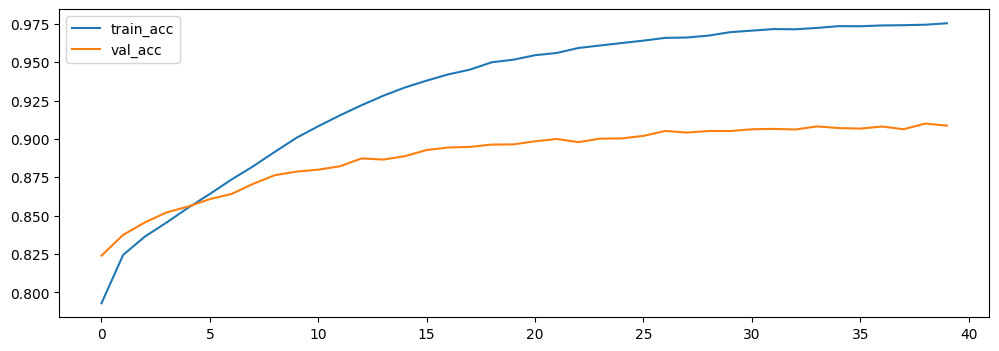

In [26]:
# 학습 결과 시각화
plt.figure(figsize=(12,4))
plt.plot(emb2_his.history['accuracy'], label='train_acc')
plt.plot(emb2_his.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [27]:
y_pre = model_embedding2.predict(X_test_vec)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [28]:
# 분류평가지표 확인
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y_test.values, y_pre))
# test 정확도 0.78
# 정밀도, 재현율 모두 클래스 별 조금의 차이는 있지만, 전반적으로 균형 잡힌 성능을 보임

              precision    recall  f1-score   support

           0       0.79      0.78      0.78     24826
           1       0.79      0.79      0.79     25171

    accuracy                           0.79     49997
   macro avg       0.79      0.79      0.79     49997
weighted avg       0.79      0.79      0.79     49997



In [33]:
# 모델의 출력값 -> 확률값 (출력층의 활성화함수인 'sigmoid' 통과 > 0~1 사이 확률 값)
# 0.5보다 크면 1, 낮으면 0 반환 (이진 분류 정답으로 만들어주기)
y_pre = np.where(y_pre>=0.5, 1, 0)